In [14]:
# coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import os
import pickle
torch.set_default_tensor_type(torch.DoubleTensor)
import warnings
warnings.filterwarnings('ignore')

In [15]:
# class SEIR_cell(torch.nn.Module):
#     def __init__(self, N, beta_init, gamma_2_init, theta_init):
#         super(SEIR_cell, self).__init__()
#         # self.date_len = date_len
#         self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
#         self.N = Parameter(torch.tensor([N], requires_grad=True))
#         self.gamma_1 = 0.
#         self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
#         self.alpha = 1.
#         self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
#         # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

#     def clamp(self, X):
#         # return torch.clamp(X, min=0, max=self.N)
#         return X

#     def forward(self, X):
#         S, confirm, Exposed, recover, dead = X
#         # self.beta = beta_old + self.beta_add
#         # self.gamma_2 = gamma_2_old + self.gamma_2_add
#         S_rest = self.clamp(S - self.beta*confirm*S/self.N) # dS/dt
#         E = self.clamp(Exposed + self.beta*confirm*S/self.N - self.alpha*Exposed) # dE/dt

#         # I = self.clamp(confirm + self.alpha*Exposed - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         # R = self.clamp(recover + self.gamma_2*confirm) # dR/dt
#         # D = self.clamp(dead + self.theta*confirm)
#         I = self.clamp(confirm + self.alpha*E - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         R = self.clamp(recover + self.gamma_2*I) # dR/dt
#         D = self.clamp(dead + self.theta*I)

#         return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [16]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
        # self.gamma_2 = Parameter(torch.tensor([0.5], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init], requires_grad=True))
        self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
        # self.theta = Parameter(torch.tensor([0.2], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        return torch.pow(X,2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - self.act(self.alpha)*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha
    
    def update_beta(self, b):
        self.beta = Parameter(torch.tensor([b], requires_grad=True))


In [78]:
class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., E_ratio_init=3., I_init=41, R_init=2., D_init=0., param={}):
        super(SEIR_model, self).__init__()
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        if param!={}:
            len_param=len(param['beta'])
            self.beta_save = param['beta']
            self.gamma_2_save = param['gamma_2']
            self.alpha_save = param['alpha']
            self.theta_save = param['theta']
            for i in range(len_param):
                beta = self.beta_save[i]
                gamma_2 = self.gamma_2_save[i]
                alpha = self.alpha_save[i]
                theta = self.theta_save[i]
                self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha))
            if self.date_len>len_param:
                for i in range(len_param, self.date_len):
                    if len_param>=1:
                        beta = self.beta_save[len_param-1]
                        gamma_2 = self.gamma_2_save[len_param-1]
                        alpha = self.alpha_save[len_param-1]
                        theta = self.theta_save[len_param-1]
                        self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha)) 
                    else:
                        self.SEIR_cells.append(SEIR_cell(self.N)) 
        else:
            for i in range(self.date_len):
                self.SEIR_cells.append(SEIR_cell(self.N)) 

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            if i == self.date_len-1: # we cannot update the last beta with grad
                self.beta = beta_cur
                self.SEIR_cells[i].update_beta(beta_cur)
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        check_positive_replace = lambda x,y:y if x <=0 else x
        if param=={}:
            N_cur=self.N
            beta=self.beta
            gamma_2=self.gamma_2
            theta=self.theta
            alpha=self.alpha
        else:
            N_cur=self.N
            beta=check_positive_replace(param['beta'],self.beta)
            gamma_2=check_positive_replace(param['gamma_2'],self.gamma_2)
            theta=check_positive_replace(param['theta'],self.theta)
            alpha=check_positive_replace(param['alpha'],self.alpha)
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur,beta,gamma_2,theta,alpha))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor


    def beta_pred(self, beta_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[beta_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['beta']
        param_dict={}
        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            print("data:",data)
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1]  
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            param_dict[param]=model.forecast(2)[0]
            print(param_dict[param])
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(dif,0,-1):
                    dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-2:]+dif_data_list[i-1][-2:])
                param_dict[param]=dif_data_list[0][-2:]
        # update beta by arima
        param_dict['beta'][0] = check_positive(param_dict['beta'][0])
        # param_dict['beta'][1] = check_positive(param_dict['beta'][1])
        self.SEIR_cells[-1].update_beta(param_dict['beta'][0])
        
        return param_dict['beta'][1]

    def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list):
        check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        sqrt_datas=[gamma_2_list,theta_list,alpha_list]
        datas = [list(np.square(d)) for d in sqrt_datas]
        params=['gamma_2','theta','alpha']
        param_dict={}

        param_dict['beta'] = self.beta_pred(beta_list[:-1])

        for i in range(len(params)):
            param=params[i]
            data=datas[i]
            data_copy=pd.DataFrame(data,columns=[param])
            dif_data=data_copy
            dif_data_list=[data_copy.values]
            dif=0
            p_value = adfuller(data_copy[param])[1]
            while p_value>0.05:
                dif=dif+1
                dif_data=dif_data.diff(1).dropna()
                dif_data_list.append(dif_data.values)
                p_value= adfuller(dif_data[param])[1] 
            pmax = int(len(data)/10) 
            qmax = int(len(data)/10)
            if dif>1:
                d=0
                data=dif_data
            else:
                d=dif
            bic_matrix = [] #bic矩阵
            for p in range(pmax+1):
                tmp = []
                for q in range(qmax+1):
                    try: #存在部分报错，所以用try来跳过报错。
                        tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
                    except:
                        tmp.append(None)
                bic_matrix.append(tmp)
            bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
            p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
            
            model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
            model.summary2() #给出一份模型报告
            param_dict[param]=model.forecast(1)[0][0]
            if dif>1:
                dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
                for i in range(1,dif+1,1):
                    dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
                param_dict[param]=dif_data_list[0][-1]
        for k,v in param_dict.items():
            param_dict[k]=check_positive(v)
        return param_dict
    
        

In [79]:
def plot_SEIRD(data, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    for a,b in zip(merge_time, I):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

def plot_param(model,city_name,data,xlen=10):
    T_name = 'time'
    time_val = data[T_name].values
    plt.figure(figsize=(xlen, 10))
    # pd.to_datetime()
    format_datetime = lambda x :f'0{x.date().month}-{x.date().day}' if x.date().month<10 else f'{x.date().month}-{x.date().day}'
    dates_list = [format_datetime(pd.to_datetime(d)) for d in time_val]
    beta = []
    gamma_2 = []
    theta = []
    alpha = []
    omega = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        omega.append((model.SEIR_cells[i].theta.detach().numpy()[0])*0.)

    print('beta:',beta)
    print('gamma_2:',gamma_2)
    print('theta:',theta)
    print('alpha:',alpha)
    print('omega:',omega)
    plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率','omega-疑似解除率']
    plot_list_sqrt = [beta,gamma_2,theta,alpha,omega]
    plot_list=[np.square(p) for p in plot_list_sqrt]
    colors=['blue','darkgreen','darkorange','red','purple']
    for i in range(len(colors)):
        plt.plot(dates_list[:len(beta)], plot_list[i],color=colors[i],label=plot_title[i],marker='x')
    for a, b in zip(range(len(beta)), beta):
        plt.annotate('%.4f' % (b), xy=(a, b), xytext=(-2, 2), textcoords='offset points', color=colors[0])
    plt.legend()
    title = 'Param changing process-'+city_name
    plt.title(title)
    plt.show()

def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    plt.savefig(city+u'累计预测')
    plt.show()
    return
    
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '预测新增确诊人数',marker = 'x')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')
    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')
    plt.ylabel('人数')
    plt.savefig(city+u'新增预测')
    plt.show()
    return

def cal_acc_confirm(I,R,D):
    return I+R+D

def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = acc_confirm[i+1]-acc_confirm[i]
    return new_confirm

def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

def save_param(model, model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    beta = []
    theta = []
    gamma_2 = []
    alpha = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
    param={'beta':beta,'theta':theta,'gamma_2':gamma_2,'alpha':alpha}
    with open(save_path + 'param.pkl', 'wb') as f:
        pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)

def load_param(model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    with open(save_path + 'param.pkl', 'rb') as f:
        return pickle.load(f)

def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, lr_init=0.01, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6., cured_ratio=20., dead_ratio=20.,
          param={}, features=['I', 'cured', 'dead'], max_epoches=6000):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, param=param)

    lr = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirmed = I+R+D
        
        I_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        confirmed_gt_tensor=I_gt_tensor+recovered_gt_tensor+dead_gt_tensor

        loss = (loss_fn(pred_confirmed, confirmed_gt_tensor) + cured_ratio*loss_fn(pred_recovered, recovered_gt_tensor) + dead_ratio*loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_I, I_gt_tensor))/(dead_ratio+cured_ratio+2.)
        print("Loss: {}".format(loss))
        loss_list.append(loss)
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    save_param(model,model_city_date_path)
    return S, I, E, R, D, loss_list

def load_model_predict(model_city_date_path, data, param_pred=True, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)
    S_pred_total = np.concatenate((S_pred_old,S_pred_new),axis=0)
    E_pred_total = np.concatenate((E_pred_old,E_pred_new),axis=0)

    plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)


    print("!!!!!!\nN:\n",S_pred_total+E_pred_total+I_pred_total+R_pred_total+D_pred_total)
    return model

def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['I/cured']=data['I']/data['cured']
    data['I/dead']=data['I']/data['dead']

    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data

def train_with_city_data(data, N, date, cityname='深圳', lr_init=0.01, max_epoches=2000,is_train=True,load_param_save=False,param_path=''):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    cured_ratio = float(data['I'].mean()/data['cured'].mean()) if data['cured'].mean()!=0 else 50.
    dead_ratio = float(data['I'].mean()/data['dead'].mean()) if data['dead'].mean()!=0 else 50.
    print('cured_ratio:',cured_ratio)
    print('dead_ratio:',dead_ratio)
    param={}
    if load_param_save:
        if param_path=='':
            param_path=model_city_date_path
        param = load_param(param_path)
    print(param)
    #train里面会保存模型
    if is_train:
        S,I,E,R,D,loss_list = train(data, model_city_date_path, lr_init=lr_init, N=N, I_init=I_init, R_init=R_init, D_init=D_init, cured_ratio=cured_ratio,dead_ratio=dead_ratio, features=features, max_epoches=max_epoches,param=param)
        plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')
    return model_city_date_path
#read data

In [80]:
# import datetime as dt
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]
datetime='02-14'
time='0213'
yesterday='02-13'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]
# for i in range(4):
#     data=read_data(paths[i])
#     city_name=citys[i]
#     N=0
#     if i == 3:
#         N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
#     else :
#         N = N_inits[i]
#     model_city_date_path = train_with_city_data(data,N,datetime,city_name)
#     load_model_predict(model_city_date_path, data, city_name=city_name)

.98645257282419
Training step:  1559
Loss: 38.98640276508542
Training step:  1560
Loss: 38.986353451895845
Training step:  1561
Loss: 38.98630402916104
Training step:  1562
Loss: 38.98625447985767
Training step:  1563
Loss: 38.986204799661365
Training step:  1564
Loss: 38.986155657948245
Training step:  1565
Loss: 38.986106441343395
Training step:  1566
Loss: 38.986056988212816
Training step:  1567
Loss: 38.98600734809513
Training step:  1568
Loss: 38.985958308991165
Training step:  1569
Loss: 38.98590929015693
Training step:  1570
Loss: 38.98586000498666
Training step:  1571
Loss: 38.98581055853413
Training step:  1572
Loss: 38.985761684866446
Training step:  1573
Loss: 38.9857127888864
Training step:  1574
Loss: 38.985663673094315
Training step:  1575
Loss: 38.9856144505112
Training step:  1576
Loss: 38.98556573503604
Training step:  1577
Loss: 38.985516971708286
Training step:  1578
Loss: 38.985467950980926
Training step:  1579
Loss: 38.985418632648404
Training step:  1580
Loss: 38.

32633

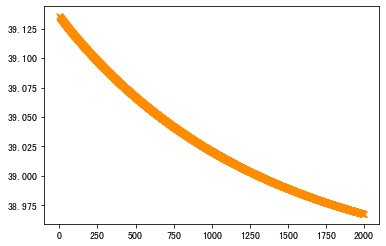

In [31]:
#hubei
param_path=''
i=0
data=read_data(paths[i])
city_name=citys[i]
# param_path=param_paths_yes[i]
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.0000001,param_path=param_path)

#34695
#GT:31728
32633

[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631 31728 33366 48206
 51986]
data: [0.34141050558685837, 0.37692741441727645, 0.463291888973819, 0.5922002254824028, 0.6385540073204303, 0.6505596488037717, 0.5825065045945681, 0.4997625806912344, 0.4628352832029961, 0.4141504966081626, 0.4130412297310404, 0.42216832304719143, 0.40043248477374727, 0.40736101169193467, 0.4255040436262217, 0.4322256859758987, 0.4642634756306369, 0.48083970135848536, 0.5245989473444412, 0.3496429661127135, 0.3042077504770437, 0.27288402124873334, 0.2889578648555305]
[0.29486158 0.2967275 ]
{'beta': 0.29672750406988885, 'gamma_2': 0.020959973263101447, 'theta': 0.004811857115033204, 'alpha': 0.0715534647040449}


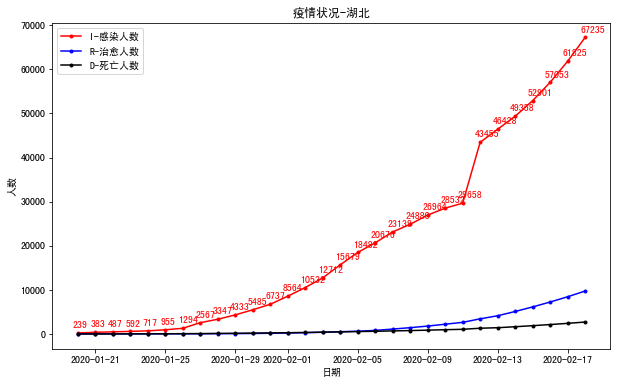

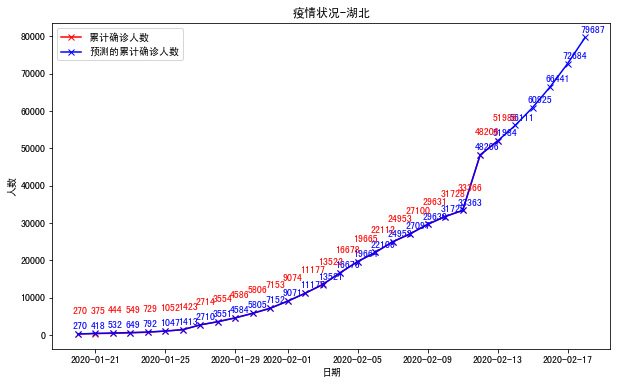

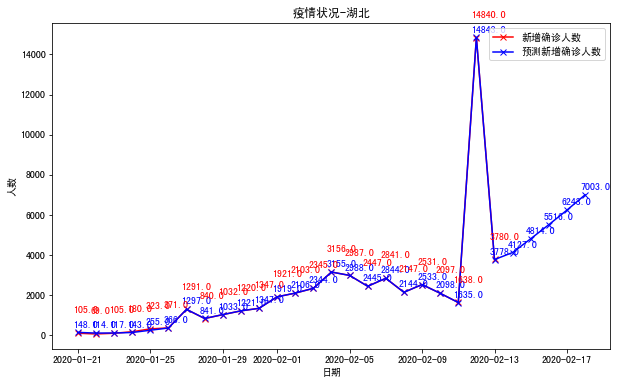

!!!!!!
N:
 [59170000 59169997 59169998 59169997 59169998 59169997 59169997 59169998
 59169998 59169997 59169998 59169998 59169996 59169999 59169998 59169997
 59169998 59169996 59169999 59169996 59169998 59169999 59169996 59169999
 59169997 59169998 59169997 59169997 59169998 59169998]


In [32]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

beta: [0.5854541874172606, 0.6143281609446247, 0.6805129683105777, 0.7683934562974771, 0.7979807829794354, 0.8057531249035752, 0.7626023044285922, 0.7067465406420627, 0.6801772303849964, 0.6434030893633514, 0.6425452237405214, 0.649548119403736, 0.6325556798613838, 0.6379748605030641, 0.6519895219647508, 0.6571198703259716, 0.6808354750453767, 0.6922834650206593, 0.7230813644582164, 0.5894003984675533, 0.5487299283727921, 0.519145169652254, 0.519145169652254, 0.3117360036560615]
gamma_2: [-0.09227261723228196, -0.08212983646056894, -0.07235237002137858, -0.07255047966052587, 0.08803463140765043, 0.061393414274461926, -0.01203673763048454, 0.11610932710881265, 0.05643617742902458, 0.07760935393106404, -0.09548697386820955, -0.08499379301691859, -0.09666187812474467, 0.0979173059462475, 0.09871867472848582, 0.0848547713319267, 0.09976692396075953, 0.11997501324310483, 0.11852167228666305, 0.11976359800669738, 0.12579987504065668, 0.12085575343631191, 0.16440322785722922, 0.12089335520835

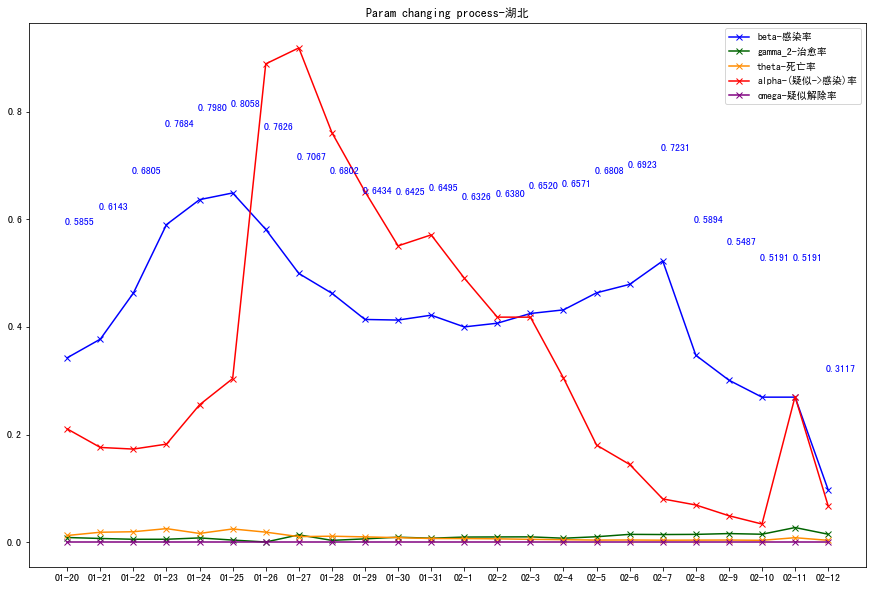

In [23]:
param = load_param(model_city_date_path)
param
# model = load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=5)
plot_param(model,city_name,data,xlen=15)

ng step:  2555
Loss: 9.79033858646646
Training step:  2556
Loss: 9.568944046531993
Training step:  2557
Loss: 9.453931603051336
Training step:  2558
Loss: 9.26119538314345
Training step:  2559
Loss: 9.324377963815918
Training step:  2560
Loss: 9.203408894285406
Training step:  2561
Loss: 9.31360609632365
Training step:  2562
Loss: 9.167513566425841
Training step:  2563
Loss: 9.311466329657286
Training step:  2564
Loss: 9.14068690837414
Training step:  2565
Loss: 9.310579614150479
Training step:  2566
Loss: 9.140444110843251
Training step:  2567
Loss: 9.31008463289927
Training step:  2568
Loss: 9.11460217467546
Training step:  2569
Loss: 9.239709770872441
Training step:  2570
Loss: 9.089266881690822
Training step:  2571
Loss: 9.238415606296776
Training step:  2572
Loss: 9.063156175573129
Training step:  2573
Loss: 9.22266156075167
Training step:  2574
Loss: 9.037603076022187
Training step:  2575
Loss: 9.149960470250187
Training step:  2576
Loss: 9.013534858992239
Training step:  2577
Lo

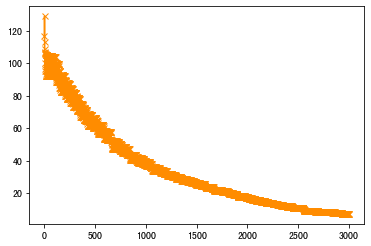

In [43]:
#wuhan

i=1
data=read_data(paths[i])
# param_path=param_paths_yes[i]
city_name=citys[i]
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=3000,is_train=True,load_param_save=True,lr_init=0.0001,param_path=param_path)

[  258   363   425   495   572   618   698  1590  1905  2261  2639  3215
  4109  5142  6384  8351 10117 11618 13603 14982 16902 18454 19558 32994
 35991]
data: [0.33403754867917723, 0.3445601969581209, 0.35987254350053194, 0.38637695626469704, 0.4151565394469567, 0.5765852620011788, 0.4214747138196741, 0.386231958556961, 0.3737589316102617, 0.37820889613304215, 0.37613638619039697, 0.3705690250929296, 0.3710974693578084, 0.38547401936310866, 0.41903427724360387, 0.5651843623786722, 0.5504097735478496, 0.4981376756260578, 0.5175390553076012, 0.3945524010655355, 0.18187228577154488, 0.22943908306848457, 0.11161672044583051]
[0.17057425 0.21517176]
{'beta': 0.21517176060529108, 'gamma_2': 0.011797902301539426, 'theta': 0.004264807463452585, 'alpha': 0.23073784138851391}


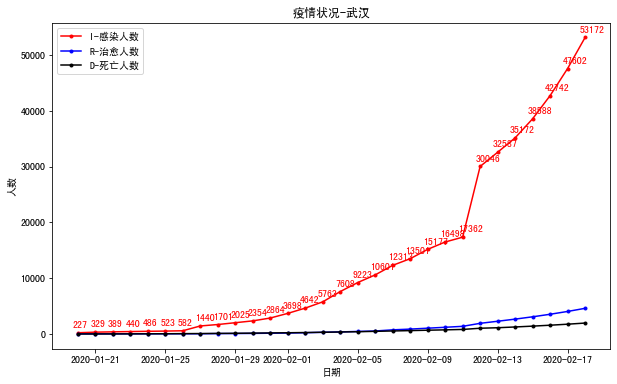

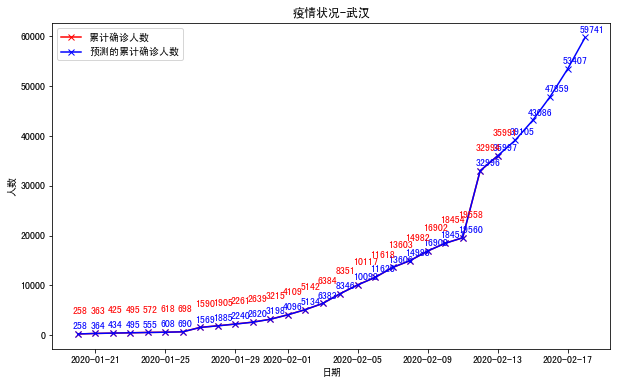

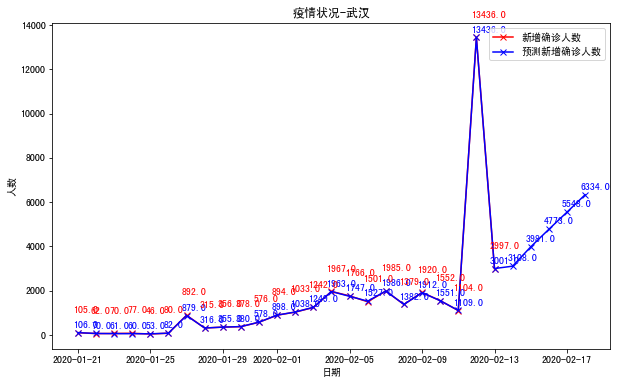

!!!!!!
N:
 [2870000 2869997 2869997 2869997 2869997 2869998 2869998 2869997 2869998
 2869998 2869998 2869997 2869997 2869997 2869997 2869998 2869997 2869998
 2869997 2869997 2869997 2869997 2869997 2869997 2869998 2869998 2869999
 2869997 2869998 2869997]
beta: [0.5779598157996603, 0.5869925016200129, 0.5998937768476449, 0.6215922749396883, 0.6443264230550821, 0.7593321157446054, 0.6492108392653916, 0.6214756298978754, 0.6113582678023269, 0.6149869072858724, 0.6132995892631895, 0.6087438090797553, 0.6091776993273871, 0.6208655404861093, 0.6473285697724177, 0.7517874449461578, 0.7418960665402193, 0.705788690491749, 0.7194018733000361, 0.6281340629718591, 0.4264648705011292, 0.47899799902346624, 0.33409088650520014, 0.1705742487082483]
gamma_2: [-0.0862905447448463, -0.07811639784612955, -0.07862207194238911, -0.0741437134409695, -0.10957826934144466, -0.08750610980822457, -0.06689364694896154, 0.15137021694127795, 0.06578385377980138, 0.1009655274784293, 0.1233930237578735, 0.1056730509

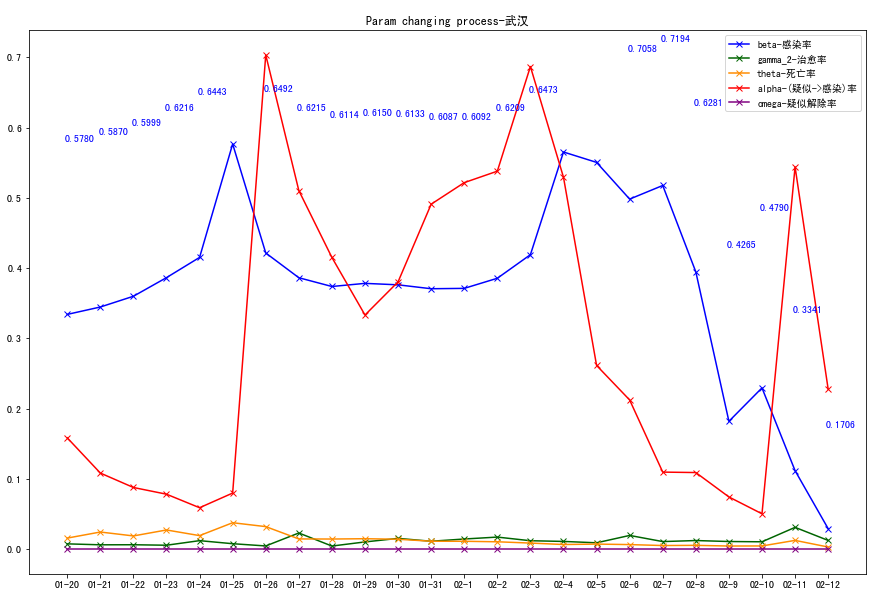

In [44]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)
plot_param(model,city_name,data,xlen=15)


cured_ratio: 8.611670020120725
dead_ratio: 50.0
{'beta': [0.6245130897562873, 0.6362222360226865, 0.6528455516345819, 0.6613507585733585, 0.584585839347403, 0.45963146871480354, 0.4093211763564252, 0.3687390405133351, 0.37756592609316997, 0.35631904221512223, 0.32756070655869063, 0.2949883968565476, 0.2512350674001149, 0.2722140832387301, 0.2772560894009394, 0.250223491763211, 0.2965467108341028, 0.2965367258501498], 'theta': [0.00025502041185337135, 0.00020050237147609465, -0.0002356093788012225, -0.00021646639411272586, 0.00022845320499767475, 0.0001613432593293091, 0.00019456504907259617, 0.00017789981215401998, 0.00036182759054504733, 0.00036906793553688716, -0.0005460248855787599, 0.00024840987525889065, -4.9799824446695824e-05, 0.0004834517611141271, -0.0008581688258527594, 5.995855201952541e-05, -0.00010217097763575496, -4.198432957909114e-06], 'gamma_2': [0.17201852861381858, 0.14734878803298845, -0.0015522408825065146, 0.007613214535137225, -1.371656682520539e-05, 0.076758490

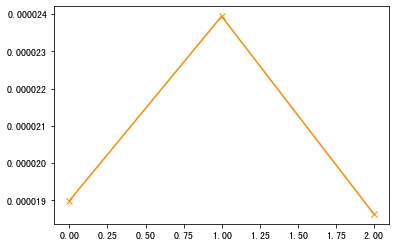

In [84]:
#shenzhen
param_path=''
i=2
data=read_data(paths[i])
city_name=citys[i]
# param_path=param_paths_yes[i]
print(param_path)
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=3,is_train=True,load_param_save=True,lr_init=0.00001,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=60)

[ 36  49  63  86 110 170 196 226 269 289 314 334 351 364 368 375 386 391
 400]
data: [0.39001658999950345, 0.40477872415795346, 0.4262073045903088, 0.43738481604023427, 0.3417405948822344, 0.21126108020614642, 0.16754381933497814, 0.1359684745247479, 0.14255602294247124, 0.12696325455883445, 0.1072960116228139, 0.08701814990773737, 0.06311905536564091, 0.07410050307416807, 0.0768709349907539, 0.0626117909807088, 0.08792810359776633]
[0.09448325 0.1007281 ]
{'beta': 0.31737690933121215, 'gamma_2': 0.22330196153838222, 'theta': 0, 'alpha': 0.2889243721031631}


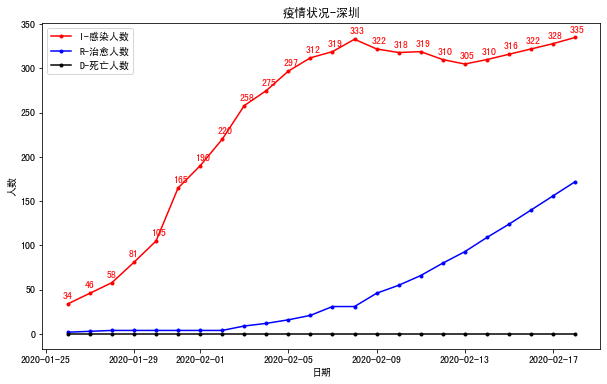

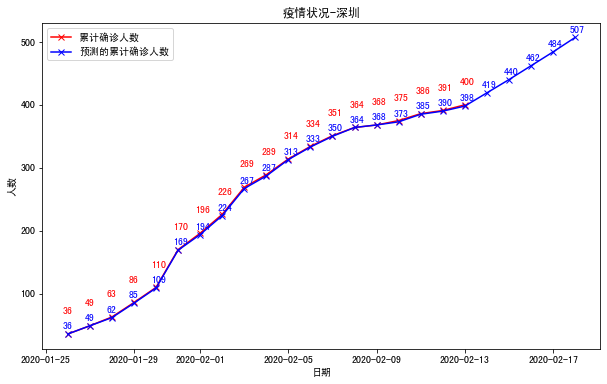

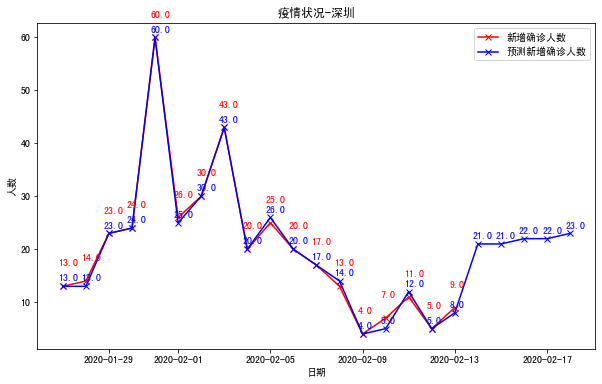

!!!!!!
N:
 [13026600 13026599 13026598 13026598 13026598 13026598 13026597 13026597
 13026597 13026597 13026598 13026598 13026598 13026599 13026599 13026597
 13026598 13026597 13026597 13026598 13026598 13026598 13026598 13026597]
beta: [0.6245130823285477, 0.6362222285946582, 0.6528455442065212, 0.661350751145135, 0.5845858319205439, 0.4596314612884397, 0.40932116893092413, 0.3687390330908133, 0.377565918671788, 0.3563190347972368, 0.32756069914263813, 0.29498838944564815, 0.251235059984949, 0.2722140758193229, 0.2772560819725221, 0.25022348207294376, 0.29652673336103497, 0.3073812754113666]
gamma_2: [0.1720185360433697, 0.1473487954626914, -0.001552248300212498, 0.007613221961971485, -1.3833732260535719e-05, 0.07673851298402143, 0.006245295151891642, 0.15048370746615147, 0.10755778513648223, 0.10439719116117868, 0.1418314981318574, 0.16992804744011014, 0.00329615590019256, 0.21217532235783615, 0.17618089319178323, 0.17715644225587748, 0.2164348858690213, 0.204689672481569]
theta: [0.

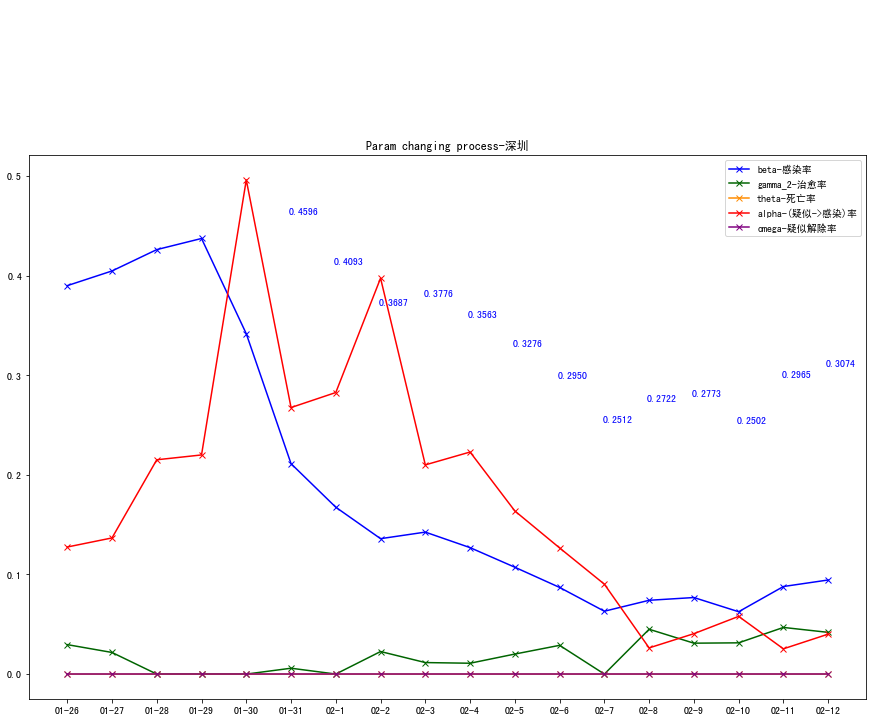

In [82]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)
plot_param(model,city_name,data,xlen=15)

[ 36  49  63  86 110 170 196 226 269 289 314 334 351 364 368 375 386 391
 400]


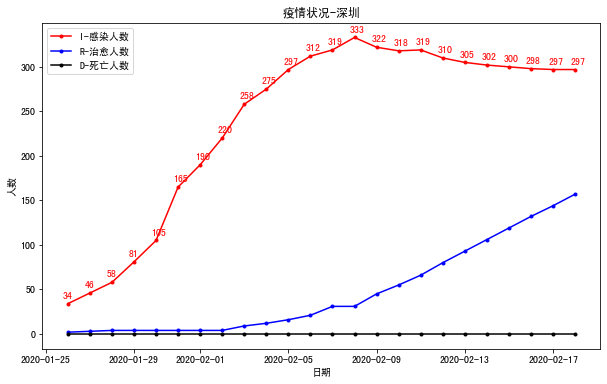

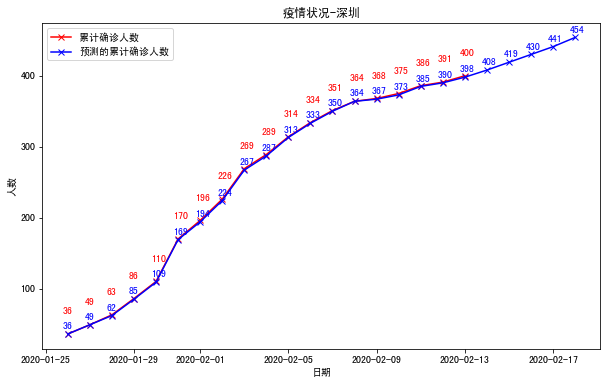

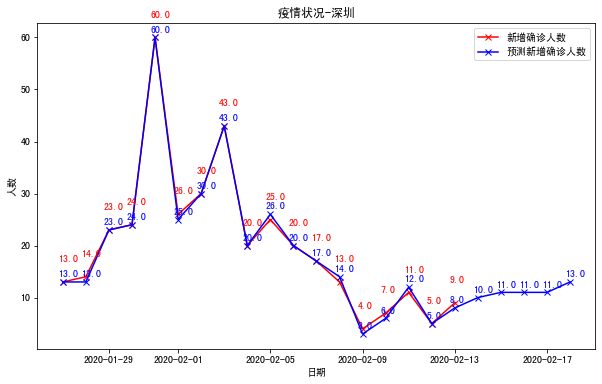

!!!!!!
N:
 [13026600 13026599 13026598 13026598 13026598 13026598 13026597 13026597
 13026597 13026597 13026598 13026598 13026598 13026599 13026598 13026597
 13026598 13026597 13026597 13026597 13026598 13026598 13026598 13026599]
beta: [0.6245130971894611, 0.6362222434561646, 0.6528455590680973, 0.6613507660070451, 0.5845858467796171, 0.4596314761464035, 0.4093211837868801, 0.3687390479395872, 0.37756593351718865, 0.35631904963314476, 0.3275607139744898, 0.2949884042665045, 0.2512350748164811, 0.27221409066075547, 0.2772560968354669, 0.2502434828050305, 0.2965667031838499, 0.2965667031838499]
gamma_2: [0.17201852117692962, 0.1473487805935658, -0.0015522322773549692, 0.007593224805420417, -1.3597535074941854e-05, 0.076758497708347, 0.006245295265841648, 0.15048370746123954, 0.10755778511836837, 0.10437722092471496, 0.14181152789436813, 0.1699080771793841, 0.003276186406138903, 0.2121753372210663, 0.17618090805844236, 0.1771564571073477, 0.21645487099036537, 0.2047096575427207]
theta: [

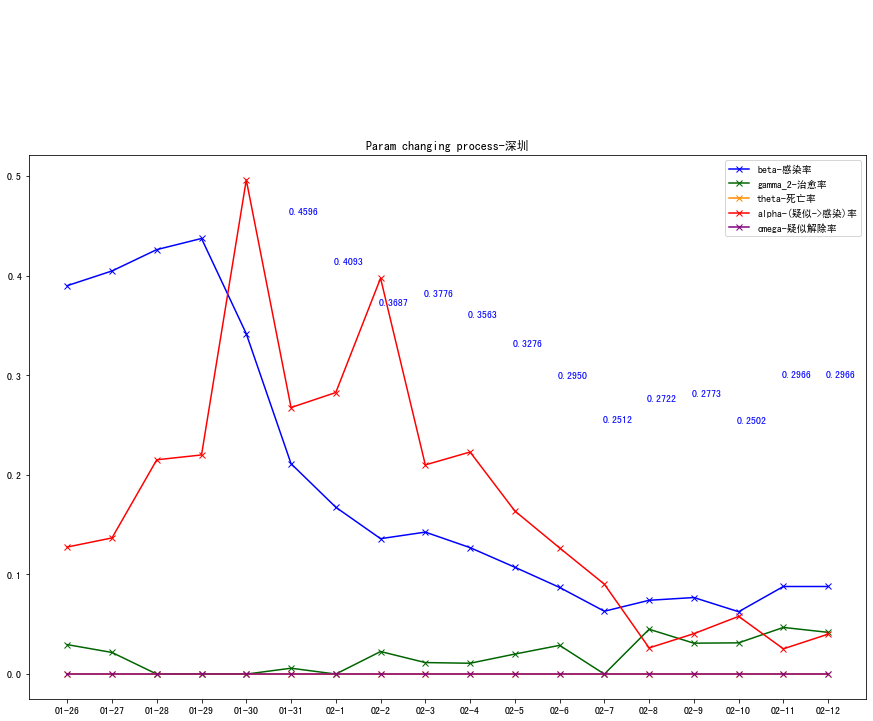

In [85]:
model = load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name)
plot_param(model,city_name,data,xlen=15)

tep:  1555
Loss: 99.22281552938105
Training step:  1556
Loss: 99.20993409521414
Training step:  1557
Loss: 99.2198159353878
Training step:  1558
Loss: 99.19882536632421
Training step:  1559
Loss: 99.21108055069853
Training step:  1560
Loss: 99.19013495958615
Training step:  1561
Loss: 99.20233107415804
Training step:  1562
Loss: 99.18146051660263
Training step:  1563
Loss: 99.19359777377473
Training step:  1564
Loss: 99.17280200452716
Training step:  1565
Loss: 99.18488061598592
Training step:  1566
Loss: 99.16415939058727
Training step:  1567
Loss: 99.17704273764176
Training step:  1568
Loss: 99.1555395541669
Training step:  1569
Loss: 99.15657450163403
Training step:  1570
Loss: 99.14489503566135
Training step:  1571
Loss: 99.15332064963121
Training step:  1572
Loss: 99.133713318853
Training step:  1573
Loss: 99.14638108707825
Training step:  1574
Loss: 99.12512459261791
Training step:  1575
Loss: 99.12767875478818
Training step:  1576
Loss: 99.11527362503922
Training step:  1577
Los

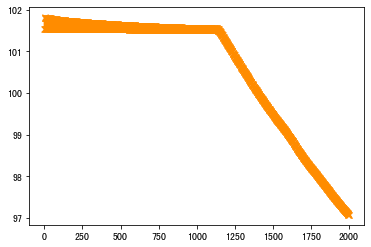

In [59]:
#china

i=3
data=read_data(paths[i])
city_name=citys[i]
# param_path='models/'+'china/02-12'
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.000008,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

[  291   440   571   830  1287  1975  2744  4515  5974  7711  9692 11791
 14380 17205 20438 24324 28018 31161 34546 37198 40171 42638 44653 52526
 55748]
data: [0.4766250543981703, 0.5362105487993714, 0.5725486517784945, 0.6706270685413619, 0.7008518959547305, 0.7349424194915315, 0.6312823235573607, 0.5164690730571696, 0.35271857708493654, 0.3270846247862528, 0.31791298327025297, 0.2982381660144567, 0.2812743676494194, 0.27372393401422435, 0.2589445706026314, 0.24628073717356838, 0.23352123856949358, 0.22706041524282802, 0.2207131312310575, 0.20050653670735777, 0.09258453256765134, 0.12653787409165074, 0.08274863554482177]
[0.13574948 0.12066995]
{'beta': 0.12066995239047104, 'gamma_2': 0.017829812013192656, 'theta': 0.0036319533174601674, 'alpha': 0.16350404285599923}


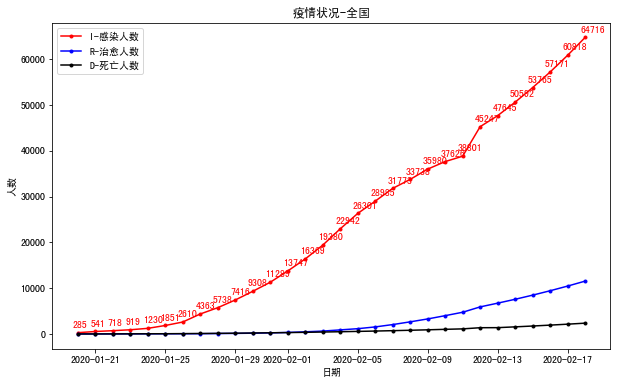

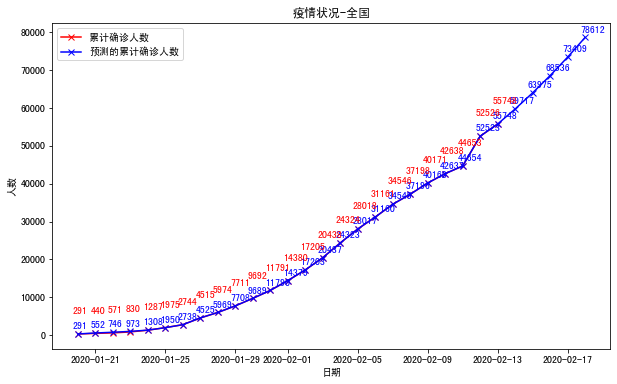

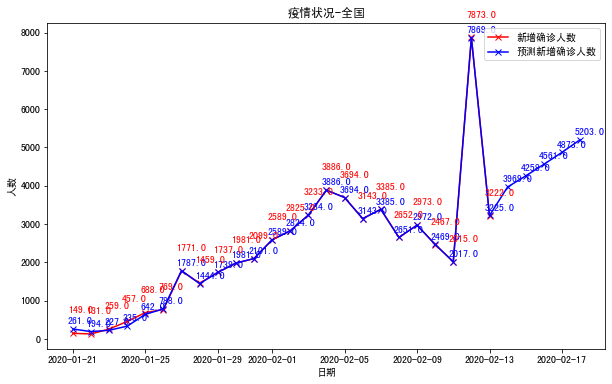

!!!!!!
N:
 [73690800 73690798 73690797 73690798 73690798 73690798 73690798 73690797
 73690796 73690798 73690796 73690799 73690798 73690798 73690797 73690798
 73690798 73690798 73690798 73690797 73690797 73690797 73690798 73690797
 73690798 73690798 73690796 73690798 73690797 73690796]
beta: [0.6903803693603768, 0.7322639884627479, 0.7566694468382442, 0.8189182306807938, 0.8371689769423677, 0.8572878276818886, 0.7945327706000305, 0.7186578275209765, 0.5939011509375416, 0.5719131269574539, 0.5638377277818973, 0.5461118621806861, 0.5303530594325061, 0.5231863281988782, 0.5088659652625939, 0.4962668003942722, 0.4832403527950595, 0.4765085678587826, 0.4698011613768718, 0.44777956262803886, 0.3042770654644404, 0.35572162443637123, 0.2876606256421302, 0.1357494770307234]
gamma_2: [0.09757899064011223, 0.12718164191547277, -0.14929123962354118, 0.10750985212484758, -0.07742074865206552, 0.05030889020613926, 0.05586335327531303, 0.09868860685455762, -0.061861630632926774, 0.0796420743987333, -0

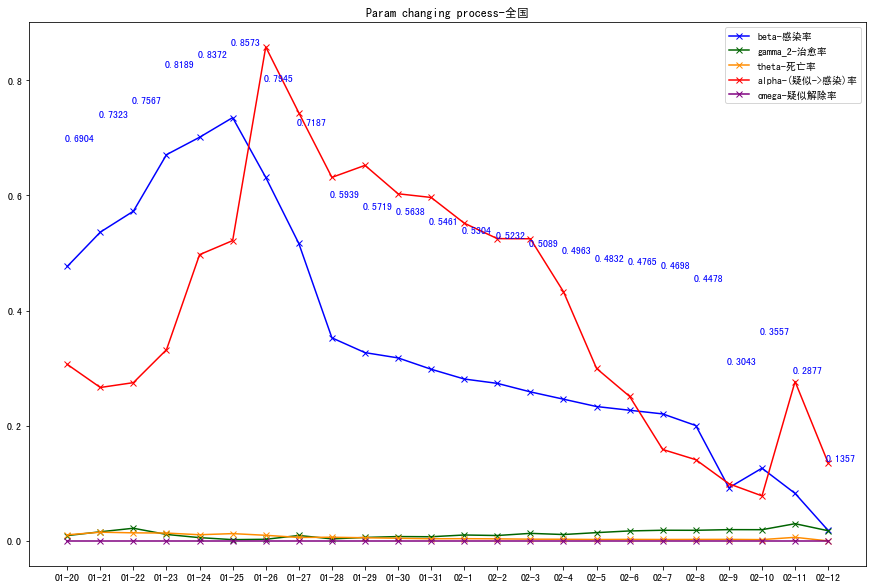

In [60]:
model = load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)
plot_param(model,city_name,data,xlen=15)

In [61]:
def format_output(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', features=['I','cured','dead'], pred_date_len=5, data_dict={'累计':{},'新增':{}},data_dict_report={'累计':{},'新增':{}}):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    cal_acc_confirm(I_pred_old,R_pred_old,D_pred_old)
    new_confirm_pred = cal_new_confirm(I_pred_old,R_pred_old,D_pred_old)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    I_pred_total = np.concatenate((I_pred_old,I_pred_new),axis=0)
    R_pred_total = np.concatenate((R_pred_old,R_pred_new),axis=0)
    D_pred_total = np.concatenate((D_pred_old,D_pred_new),axis=0)

    # plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    # plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)

    T_name = 'time'
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    format_datetime = lambda x :f'0{x.date().month}-{x.date().day}' if x.date().month<10 else f'{x.date().month}-{x.date().day}'
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    data_dict_report['累计'][city_name] = dict.fromkeys(dates_list)
    data_dict_report['新增'][city_name] = dict.fromkeys(dates_list)
    temp=[]
    for i,p in enumerate(confirm_pred):
        data_dict['累计'][city_name].append([dates_list[i],p])
        data_dict_report['累计'][city_name][dates_list[i]]=p
    for i,p in enumerate(new_confirm_pred_total):
        data_dict['新增'][city_name].append([dates_list[i+1],p])
        data_dict_report['新增'][city_name][dates_list[i+1]]=p
    return data_dict,data_dict_report

date_time='02-14'
time='0213'
citys=['湖北','武汉','全国','深圳']
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv']
modelpath=['./models/hubei/'+date_time,'./models/wuhan/'+date_time,'./models/china/'+date_time,'./models/shenzhen/'+date_time]
# starts_date=['2020-01-20','2020-01-20','2020-01-20','2020-01-26'] #深圳从2020-01-26开始
# end_date=get_today_date()
def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    data=read_data(paths[i])
    data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print(data_dict)
# print(data_dict_report)

data: [0.34141050558685837, 0.37692741441727645, 0.463291888973819, 0.5922002254824028, 0.6385540073204303, 0.6505596488037717, 0.5825065045945681, 0.4997625806912344, 0.4628352832029961, 0.4141504966081626, 0.4130412297310404, 0.42216832304719143, 0.40043248477374727, 0.40736101169193467, 0.4255040436262217, 0.4322256859758987, 0.4642634756306369, 0.48083970135848536, 0.5245989473444412, 0.3496429661127135, 0.3042077504770437, 0.27288402124873334, 0.2889578648555305]
[0.29486158 0.2967275 ]
{'beta': 0.29672750406988885, 'gamma_2': 0.020959973263101447, 'theta': 0.004811857115033204, 'alpha': 0.0715534647040449}
data: [0.33403754867917723, 0.3445601969581209, 0.35987254350053194, 0.38637695626469704, 0.4151565394469567, 0.5765852620011788, 0.4214747138196741, 0.386231958556961, 0.3737589316102617, 0.37820889613304215, 0.37613638619039697, 0.3705690250929296, 0.3710974693578084, 0.38547401936310866, 0.41903427724360387, 0.5651843623786722, 0.5504097735478496, 0.4981376756260578, 0.51753

In [62]:
print(data_dict_report)

{'累计': {'湖北': {'01-20': 270, '01-21': 418, '01-22': 532, '01-23': 649, '01-24': 792, '01-25': 1047, '01-26': 1413, '01-27': 2710, '01-28': 3551, '01-29': 4584, '01-30': 5805, '01-31': 7152, '02-1': 9071, '02-2': 11177, '02-3': 13521, '02-4': 16676, '02-5': 19664, '02-6': 22109, '02-7': 24953, '02-8': 27097, '02-9': 29630, '02-10': 31728, '02-11': 33363, '02-12': 48206, '02-13': 51984, '02-14': 56111, '02-15': 60925, '02-16': 66441, '02-17': 72684, '02-18': 79687}, '武汉': {'01-20': 258, '01-21': 364, '01-22': 434, '01-23': 495, '01-24': 555, '01-25': 608, '01-26': 690, '01-27': 1569, '01-28': 1885, '01-29': 2240, '01-30': 2620, '01-31': 3198, '02-1': 4096, '02-2': 5134, '02-3': 6383, '02-4': 8346, '02-5': 10093, '02-6': 11620, '02-7': 13606, '02-8': 14988, '02-9': 16900, '02-10': 18451, '02-11': 19560, '02-12': 32996, '02-13': 35997, '02-14': 39105, '02-15': 43086, '02-16': 47859, '02-17': 53407, '02-18': 59741}, '全国': {'01-20': 291, '01-21': 552, '01-22': 746, '01-23': 973, '01-24': 130

In [64]:
data_dict = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    data=read_data(paths[i])
    data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print('SEIRD-ARIMA:')
for i in range(len(citys)):
    city_name=citys[i]
    s = '{}:{}'.format(city_name,data_dict_report['累计'][city_name]['02-14'])
    print(s)
# print('SEIRD')
# for i in range(len(citys)):
#     city_name=citys[i]
#     if city_name=='全国':
#         continue
#     s = '{}:{}'.format(city_name,data_dict_report_2['累计'][city_name]['02-13'])
#     print(s)


data: [0.34141050558685837, 0.37692741441727645, 0.463291888973819, 0.5922002254824028, 0.6385540073204303, 0.6505596488037717, 0.5825065045945681, 0.4997625806912344, 0.4628352832029961, 0.4141504966081626, 0.4130412297310404, 0.42216832304719143, 0.40043248477374727, 0.40736101169193467, 0.4255040436262217, 0.4322256859758987, 0.4642634756306369, 0.48083970135848536, 0.5245989473444412, 0.3496429661127135, 0.3042077504770437, 0.27288402124873334, 0.2889578648555305]
[0.29486158 0.2967275 ]
{'beta': 0.29672750406988885, 'gamma_2': 0.020959973263101447, 'theta': 0.004811857115033204, 'alpha': 0.0715534647040449}
data: [0.33403754867917723, 0.3445601969581209, 0.35987254350053194, 0.38637695626469704, 0.4151565394469567, 0.5765852620011788, 0.4214747138196741, 0.386231958556961, 0.3737589316102617, 0.37820889613304215, 0.37613638619039697, 0.3705690250929296, 0.3710974693578084, 0.38547401936310866, 0.41903427724360387, 0.5651843623786722, 0.5504097735478496, 0.4981376756260578, 0.51753

In [ ]:
for i in range(len(citys)):
    city_name=citys[i]
    if city_name=='全国':
        continue
    data=read_data(paths[i])
    if city_name=='深圳':
        data_dict = format_output(modelpath[i], data, param_pred=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)
    else:
        data_dict = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict)

In [ ]:
citys=['湖北','武汉','全国','深圳']
def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict